In [1]:
%load_ext tikzmagic
%matplotlib inline

In [2]:
import os
import sys
from collections import namedtuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from colormaps import viridis  # DEATH TO JET!

# Add my Python utils to the path
sys.path.append(os.path.join('..', 'Sean', 'py_utils'))

from pgm import read_pgm
from raw import read_raw

# Neural Network Image Processing with Pylearn2 for the JPL Space Design Competition

## or: How I Learned to Stop Worrying and Love the Net

---

https://wiki.cites.illinois.edu/wiki/display/jplteam

April, 2015, the aerospace department hosted a competition put on in conjunction with the NASA Jet Propulsion Laboratory which asked students to build an algorithm to identify safe landing zones on a series of hypothetical planetary surfaces given a limited set of overhead images and terrain data.  While this sort of task is very important for NASA, nearly identical classification tasks can easily by construction for other industrial applications, such as landing drones (think Amazon drone delivery).

Because this is a classification problem with a large component being image processing, we figured machine learning would be very well suited.  We have in this problem a clear set of geometric constraints, and at the outset, we were unsure if we could construct an algorithm that would be able to handle all of the different constraints.

In [3]:
# Define the locations of things
train_dir = os.path.join("..", "training data", "terrainS{slope}C{crater}R{rough}_100")
pgm_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{rough}_100.pgm")
raw_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{rough}_100_500by500_dem.raw")
soln_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{rough}_100.invHazard.pgm")

difficulty = namedtuple("Difficulty", ["slope", "crater", "roughness"])
diffs = list(map(lambda x: difficulty(*x), [(0, 0, 10), (4, 0, 10), (4, 4, 10), (4, 4, 20)]))

# Problem

**Can we use neural networks to identify "safe" landing sites on a planetary surface?**

For each potential landing site (100 m x 100 m), we are given two sets of data:

1. The terrain height, with a resolution of 0.2 m (500x500 pixels), as a raw file of 32-bit floats

2. An overhead image of the landing site, with the sun from the east at 30° above the horizon, with a resolution of 0.1 m (1000x1000 pixels), as a pgm image file of 8-bit integers

In this scenario, this data would correspond to a coarse satelite imaging of the surface and a snapshot taken by the rover during the descent, respectively.  Because of the relatively low sampling density, brute forcing the problem from the height data alone is not sufficient, we need some intelligent data processing scheme.

From these two sets of data, we must construct a corresponding 1000x1000 pixel map of acceptable landing locations.

## Geometric Constraints

The rover that we must consider is one with the following dimensions:

![](lander.svg)

For a given location to be considered safe, the rover must be able to land safely in all rotational configurations about its center.

There are two key constraints that disqualify a potential landing zone:

### Slope hazards

If the landing spot of the rover is at too great a slope, the rover runs the risk of toppling over. The maximum allowed tilt from vertical is 10°.

![](slope_hazard.svg)

### Roughness hazards

There must be nothing below the rover that will make contact with the lower base of the rover, so there must be clearance over any rock or similar hazard.

![](roughness_hazard.svg)

----

# Provided Information

$\rightarrow$ 4 Training sets of varying difficulty

Easiest landing site only has roughness hazards (rocks), then slopes, craters, and additional roghness are added in succession for each of the three subsequent data sets.  For each data set, the height and image data, as noted above, are provided, in addition to the correct solution.

The algorithm is judged on its ability to solve not only the provided sets of data, but another batch of 4 data sets on the day of the competition.

## Height Data

In [4]:
vmax = max(np.max(read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)) for d in diffs)
vmin = min(np.min(read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)) for d in diffs)

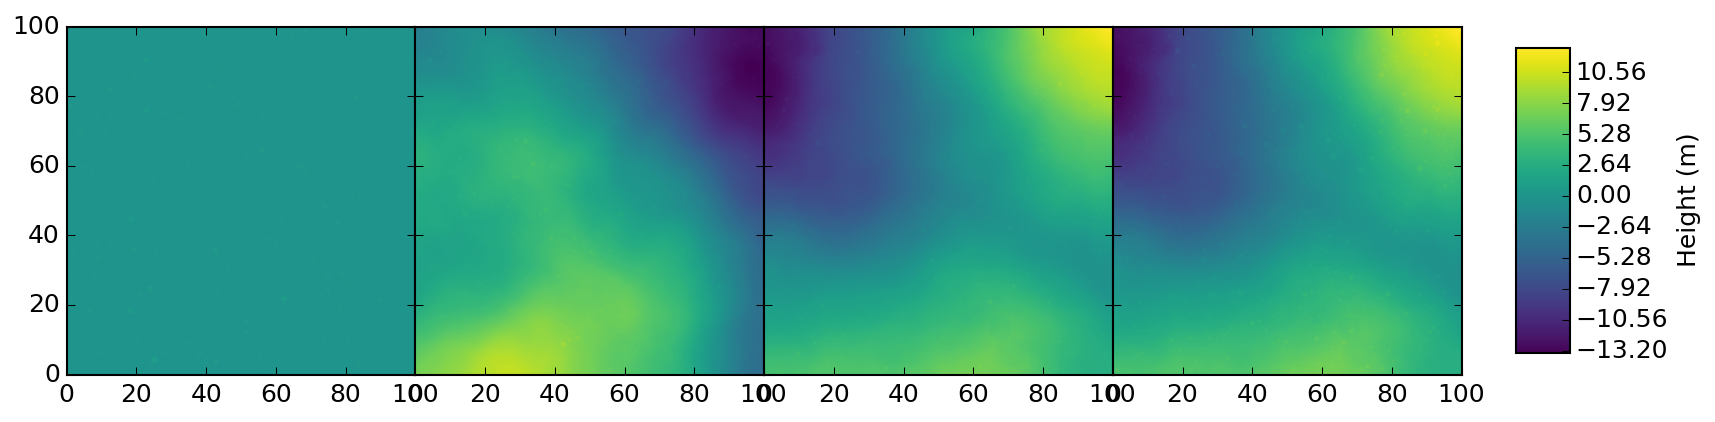

In [9]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 2.9)

x = np.linspace(0, 100, 500)
X, Y = np.meshgrid(x, x)

for i, d in enumerate(diffs):
    # Here's the data we'll plot
    raw = read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)
    
    ax = axs[i]
    
    cf = ax.contourf(X, Y, raw, 500, cmap=viridis, vmax=vmax, vmin=vmin)
    
    ax.set_aspect('equal')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

fig.subplots_adjust(hspace=0, wspace=0, right=0.9)
cb_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
cb = fig.colorbar(cf, cax=cb_ax)
cb.set_label('Height (m)')

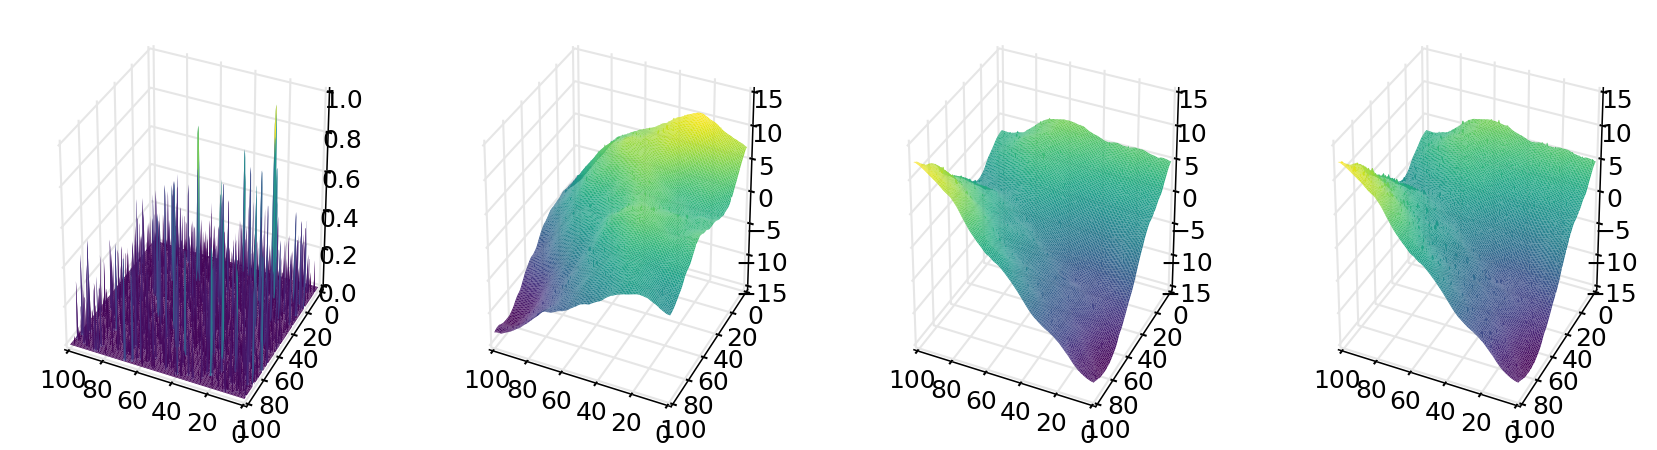

In [6]:
fig = plt.figure()
fig.set_size_inches(14, 3.5)

x = np.linspace(0, 100, 500)
X, Y = np.meshgrid(x, x)

for i, d in enumerate(diffs, start=1):
    # Here's the data we'll plot
    raw = read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)

    ax = fig.add_subplot(1, 4, i, projection='3d')
    ax.plot_surface(X, Y, raw, rstride=4, cstride=4, cmap=viridis, lw=0)
    
    ax.w_xaxis.pane.set_visible(False)
    ax.w_yaxis.pane.set_visible(False)
    ax.w_zaxis.pane.set_visible(False)
    
    ax.view_init(azim=115)

## Image data

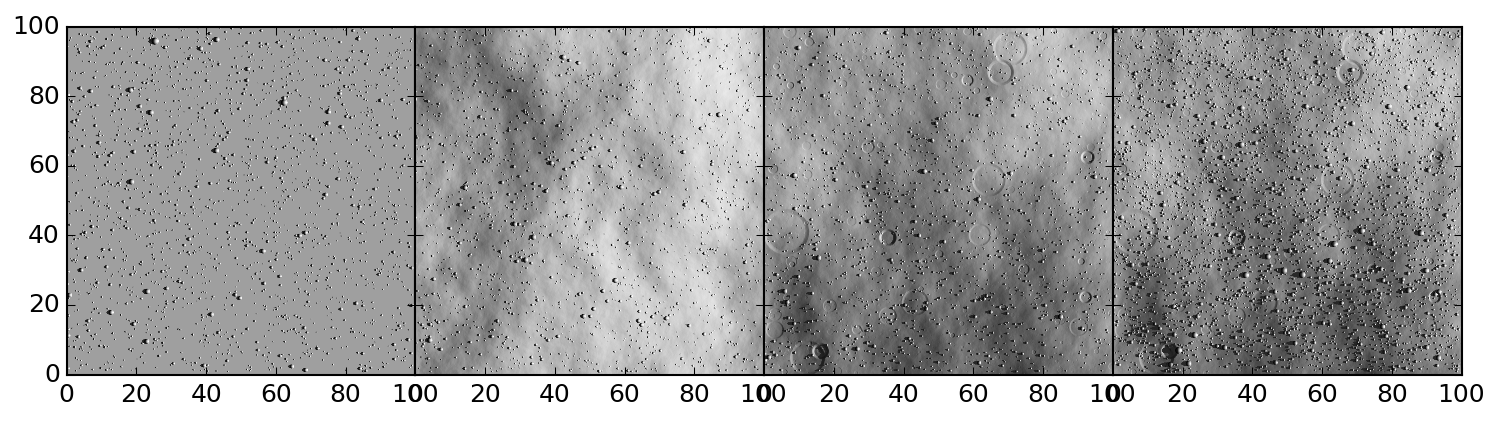

In [8]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 2.9)

for i, d in enumerate(diffs):
    # Here's the data we'll plot
    pgm = read_pgm(pgm_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    
    ax = axs[i]
    ax.imshow(pgm, cmap=mpl.cm.gray, extent=(0, 100, 0, 100))
    
fig.subplots_adjust(hspace=0, wspace=0)

## Solutions

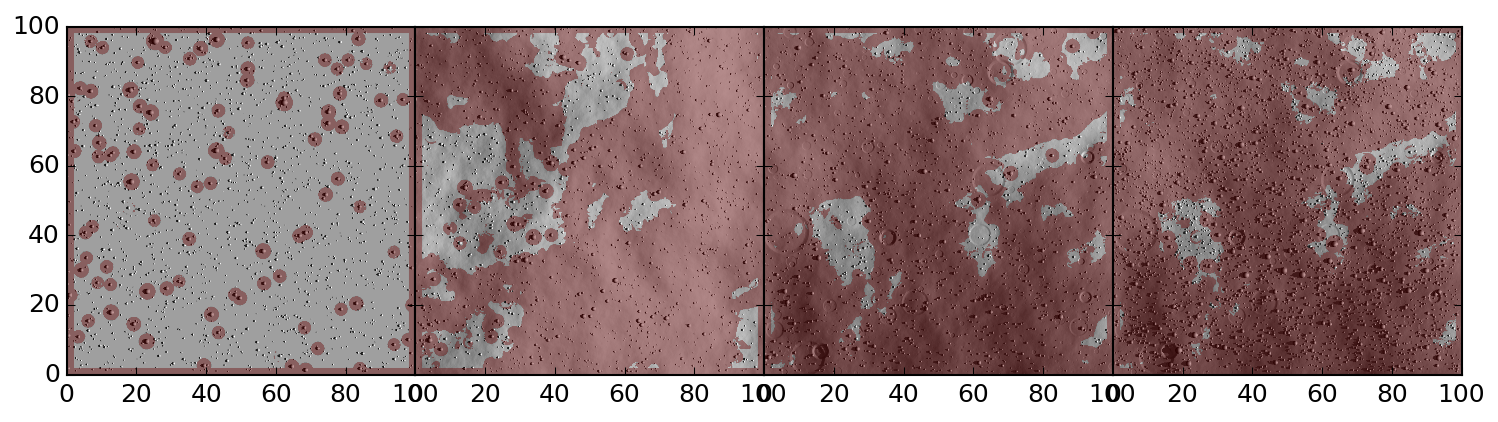

In [11]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 2.9)

for i, d in enumerate(diffs):
    pgm = read_pgm(pgm_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    soln = read_pgm(soln_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    
    soln_overlay = np.ones((soln.shape[0], soln.shape[1], 4), dtype=np.uint8) * 255
    soln_overlay[:,:,2] = soln_overlay[:,:,1] = soln  # make it red
    soln_overlay[:,:,3] = (255 - soln) * 0.4  # only color red, with alpha mask
    
    ax = axs[i]
    ax.imshow(pgm, cmap=mpl.cm.gray, extent=(0, 100, 0, 100))
    ax.imshow(soln_overlay, extent=(0, 100, 0, 100))
    
fig.subplots_adjust(hspace=0, wspace=0)

# Neural Network Basics

For our problem, we must take a set of input data, namely the height and image data about a particular landing site, and use that to classify if we can safely land in that location. To do this, we use a neural network. Here we will cover what exactly a neural network is and how we can use a neural network to perform a classification.

## Neural Nets as Linear regression

In the most simple form (no activation function, zero bias), a neural network is a fancy way of saying a complex linear mapping. That is to say we take our set of input parameters as a vector and multiply it by a matrix to map it onto the space of possible outputs, that is "safe" and "unsafe". That is we can think of mapping from the input space to the output space as:
$$y = W^{(1)}x$$
where $x$ is the input parameters, $y$ is the output, and $W^{(1)}$ is a matrix that maps from the input to the output. In our example, $x$ is the height and image data and $y$ is a two-dimensinal vector:
$$y = \begin{bmatrix} y_{safe} \\ y_{unsafe} \end{bmatrix}$$
This is termed a one-hot representation, where for classified points
\begin{align}
  \mathrm{safe}\ \Rightarrow\ y&=\begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
  \mathrm{unsafe}\ \Rightarrow\ y&=\begin{bmatrix} 0 \\ 1 \end{bmatrix}
\end{align}
The idea here is for a given input, the larger of the two values will be our classification for the input. With a proper normalization, the values of $y$ can correspond to the predicted probability of each of the options. We call the $W^{(i)}$ matrices the weight matrix, and each individual element $w^{(i)}_{j,k}$ is termed the weight, which weights the influence of the $k$th element of $x$ on the $j$th element of $y$.

A schematic of this is shown below:

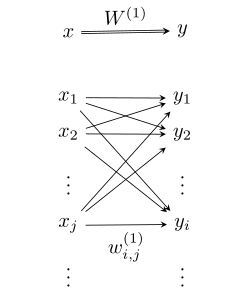

In [12]:
%%tikz -f svg -l matrix,positioning --size 250,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=4em]
{ x_1 & y_1 \\
  x_2 & y_2 \\
  \vdots & \vdots \\
  x_j & y_i \\
  \vdots & \vdots \\};
\path[-stealth]
  (m-1-1) edge (m-1-2)
  (m-1-1) edge (m-2-2)
  (m-1-1) edge (m-4-2)
  (m-2-1) edge (m-1-2)
  (m-2-1) edge (m-2-2)
  (m-2-1) edge (m-4-2)
  (m-4-1) edge (m-1-2)
  (m-4-1) edge (m-2-2)
  (m-4-1) edge node [below] {$w^{(1)}_{i,j}$} (m-4-2);
\node (x) [above=2em of m-1-1] {$x$}
 node (y) [above=2em of m-1-2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (y);

## Adding neurons

Essentially, at this point, this is a glorified multidimensional linear regresion. Here comes the "neuron" part. What we do is break up the single matrix step into multiple matrices. In this case, what we end up with in the end is equivalent, but this step will let us do interesting things with these intermediate values.  Take in this case three matrices, so now:
$$y = W^{(3)} W^{(2)} W^{(1)} x$$

The intermediate values, which we call $h^{(i)}$ are the so called hidden layers, and each element in a hidden layer corresponds to a neuron. Our new schematic looks like:

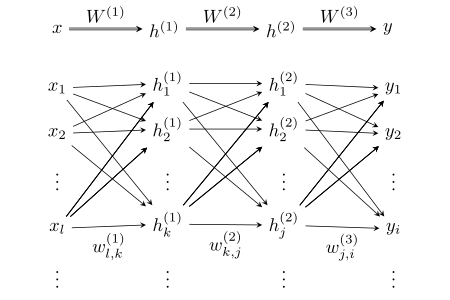

In [13]:
%%tikz -f svg -l matrix,positioning --size 450,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=4em]
{ x_1 & h^{(1)}_1 & h^{(2)}_1 & y_1 \\
  x_2 & h^{(1)}_2 & h^{(2)}_2 & y_2 \\
  \vdots & \vdots & \vdots & \vdots \\
  x_l & h^{(1)}_k & h^{(2)}_j & y_i \\
  \vdots & \vdots & \vdots & \vdots \\};
\foreach \i in {1,2} {
  \foreach \j in {1,2,4} {
    \path[-stealth] (m-\i-1) edge (m-\j-2)
                    (m-4-1) edge (m-\i-2)
                    (m-\i-2) edge (m-\j-3)
                    (m-4-2) edge (m-\i-3)
                    (m-\i-3) edge (m-\j-4)
                    (m-4-3) edge (m-\i-4);
  }
}
\path [-stealth]
  (m-4-1) edge node [below] {$w^{(1)}_{l,k}$} (m-4-2)
  (m-4-2) edge node [below] {$w^{(2)}_{k,j}$} (m-4-3)
  (m-4-3) edge node [below] {$w^{(3)}_{j,i}$} (m-4-4);
    
\node (x) [above=2em of m-1-1] {$x$}
 node (h1) [right=4em of x] {$h^{(1)}$}
 node (h2) [right=4em of h1] {$h^{(2)}$}
 node (y) [right=4em of h2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (h1)
 (h1) edge [double] node [above] {$W^{(2)}$} (h2)
 (h2) edge [double] node [above] {$W^{(3)}$} (y);

Note that we have not specified the dimensionality of any of the intermediate vectors, such that we can have arbitrarily many hidden layers and arbitrarily many elements in each hidden layer.

## Making neurons behave like neurons

At this point, the neurons are just superflous intermediate terms in a large matrix product. Because we just have a linear regression model, there we are not able to model interesting higher order behavior. To do this, we make our hidden layers behave more like neurons.

To do this, we apply to each hidden element an activation function. The idea here is if we map a very large value onto our neuron, it turns on and contributes to the next layer, where as if a very small value is mapped onto the neuron, it turns off and does not contibute to the subsequent layer of calculation. This is how the neuron analogy works in, by properly selecting the weights, we can activate or suppress the action of certain neurons, thus leading to pathways which can enforce and suppress each other to activate one or the other output.

A classic choice of activation function is the sigmoid function. The sigmoid function is defined as:
$$S(x) = \left(1 + e^{-x}\right)^{-1}$$
The sigmoid is a nice choice because it smoothly transitions from 0 to 1.  The plot of the sigmoid looks like:

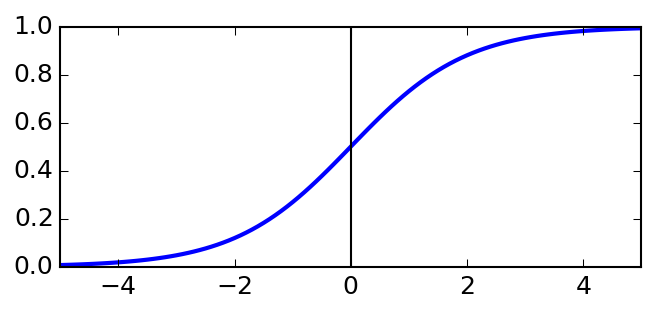

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 2)

x = np.linspace(-5, 5, 101)
y = 1 / (1 + np.exp(-x))

ax.plot(x, y, lw=2)
ax.plot([0, 0], [0, 1], 'k-')
ax.set_xlim(-5, 5)

We see that it goes to 1 in the limit $x \rightarrow \infty$, corresponding to the neuron being activated, and it goes to 0 in the limit $x \rightarrow -\infty$, corresponding to the neuron being deactivated.

A key here is that by applying this function to each neuron before we calculate the subsequent layer means we no longer have a linear function. This step of applying a non-linear function at each of the neurons is sufficient to make the neural net capable of modeling complex behavior and determining higher-order patterns in the data.

At this point, we have the following setup:

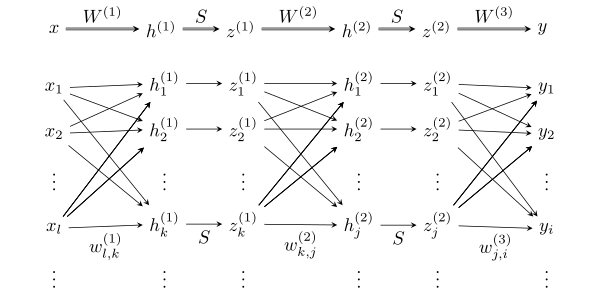

In [15]:
%%tikz -f svg -l matrix,positioning --size 600,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=2em]
{ x_1 && h^{(1)}_1 & z^{(1)}_1 && h^{(2)}_1 & z^{(2)}_1 && y_1 \\
  x_2 && h^{(1)}_2 & z^{(1)}_2 && h^{(2)}_2 & z^{(2)}_2 && y_2 \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\
  x_l && h^{(1)}_k & z^{(1)}_k && h^{(2)}_j & z^{(2)}_j && y_i \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\};
\foreach \i in {1,2} {
  \path[-stealth] (m-\i-3) edge (m-\i-4)
                  (m-\i-6) edge (m-\i-7);
  \foreach \j in {1,2,4} {
    \path[-stealth] (m-\i-1) edge (m-\j-3)
                    (m-4-1) edge (m-\i-3)
                    (m-\i-4) edge (m-\j-6)
                    (m-4-4) edge (m-\i-6)
                    (m-\i-7) edge (m-\j-9)
                    (m-4-7) edge (m-\i-9);
  }
}
\path[-stealth]
  (m-4-1) edge node [below] {$w^{(1)}_{l,k}$} (m-4-3)
  (m-4-3) edge node [below] {$S$} (m-4-4)
  (m-4-4) edge node [below] {$w^{(2)}_{k,j}$} (m-4-6)
  (m-4-6) edge node [below] {$S$} (m-4-7)
  (m-4-7) edge node [below] {$w^{(3)}_{j,i}$} (m-4-9);
 
\node (x) [above=2em of m-1-1] {$x$}
 node (h1) [right=4em of x] {$h^{(1)}$}
 node (z1) [right=2em of h1] {$z^{(1)}$}
 node (h2) [right=4em of z1] {$h^{(2)}$}
 node (z2) [right=2em of h2] {$z^{(2)}$}
 node (y) [right=4em of z2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (h1)
 (h1) edge [double] node [above] {$S$} (z1)
 (z1) edge [double] node [above] {$W^{(2)}$} (h2)
 (h2) edge [double] node [above] {$S$} (z2)
 (z2) edge [double] node [above] {$W^{(3)}$} (y);

## Adding a bias

The final step is to add a bias to each of the neurons.  This bias value sets the default behavior of the neuron, whether it defaults to be more or less activated. Using the matrix notation from above, we can say a hidden layer $i$ is assigned a vector of bias values $b^{(i)}_j$ which adds to the $h^{(i)}_j$ value before the activation is computed.  Calling the activation of the $i$th hidden layer as $z^{(i)}$, adopting the above matrix convention, the final expression for the activation of a hidden layer is:
$$ z^{(i)} = S\left(W^{(i)} z^{(i-1)} + b^{(i)}\right)$$
where the sigmoid function, $S$, is applied element-wise.  In this expression, the final output $y$ is computed in the same way using the last hidden layer as $z^{(i-1)}$, and we can think of the input data $x$ as being the $z^{(0)}$ activation.

The final graphical representation of this is:

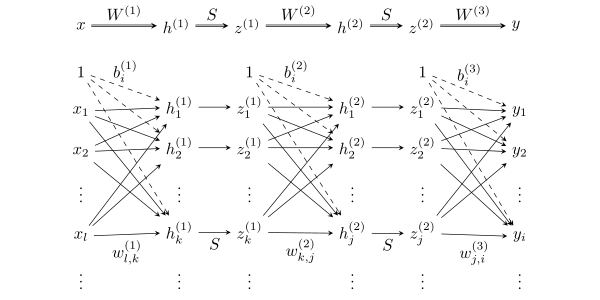

In [16]:
%%tikz -f svg -l matrix,positioning --size 600,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=2em]
{ 1 &&& 1 &&& 1 && \\
  x_1 && h^{(1)}_1 & z^{(1)}_1 && h^{(2)}_1 & z^{(2)}_1 && y_1 \\
  x_2 && h^{(1)}_2 & z^{(1)}_2 && h^{(2)}_2 & z^{(2)}_2 && y_2 \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\
  x_l && h^{(1)}_k & z^{(1)}_k && h^{(2)}_j & z^{(2)}_j && y_i \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\};
\foreach \i in {2,3} {
  \path[-stealth] (m-\i-3) edge (m-\i-4)
                  (m-\i-6) edge (m-\i-7)
                  (m-5-1) edge (m-\i-3)
                  (m-5-4) edge (m-\i-6)
                  (m-5-7) edge (m-\i-9);
  \foreach \j in {2,3,5} {
    \path[-stealth] (m-\i-1) edge (m-\j-3)
                    (m-\i-4) edge (m-\j-6)
                    (m-\i-7) edge (m-\j-9);
  }
}

\foreach \i in {3,5} {
  \path[-stealth,dashed] (m-1-1) edge (m-\i-3)
                         (m-1-4) edge (m-\i-6)
                         (m-1-7) edge (m-\i-9);
}

\path[-stealth,dashed] (m-1-1) edge node [above] {$b^{(1)}_i$} (m-2-3)
                       (m-1-4) edge node [above] {$b^{(2)}_i$} (m-2-6)
                       (m-1-7) edge node [above] {$b^{(3)}_i$} (m-2-9);

\path[-stealth]
  (m-5-1) edge node [below] {$w^{(1)}_{l,k}$} (m-5-3)
  (m-5-3) edge node [below] {$S$} (m-5-4)
  (m-5-4) edge node [below] {$w^{(2)}_{k,j}$} (m-5-6)
  (m-5-6) edge node [below] {$S$} (m-5-7)
  (m-5-7) edge node [below] {$w^{(3)}_{j,i}$} (m-5-9);
 
\node (x) [above=4em of m-2-1] {$x$}
 node (h1) [right=4em of x] {$h^{(1)}$}
 node (z1) [right=2em of h1] {$z^{(1)}$}
 node (h2) [right=4em of z1] {$h^{(2)}$}
 node (z2) [right=2em of h2] {$z^{(2)}$}
 node (y) [right=4em of z2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (h1)
 (h1) edge [double] node [above] {$S$} (z1)
 (z1) edge [double] node [above] {$W^{(2)}$} (h2)
 (h2) edge [double] node [above] {$S$} (z2)
 (z2) edge [double] node [above] {$W^{(3)}$} (y);

## Adding a softmax layer

At the end, we have some vector of outputs $y$, but these are not normalized in any meaningful way. In order to normalize and assign probabilities, we add what is called a softmax layer. To draw a statistical mechanics analogy that physicists will appreciate, we can take the output we have computed to be something like an energy state, $-E$, of a system. At this point, we can compute the probability for a system to be in any one of the given states with the Boltzmann distribution.  For some given inputs, $x$, we can assign probabilities to each of the output states as:
$$p_i(x) = \frac{e^{y_i(x)}}{\sum_i e^{y_i(x)}}$$
where the $y_i(x)$ are the values computed above.

## Assessing goodness of fit

The next thing we want is to make our neural net good at making predictions, but first we need some way to say how good the neural network performs. To do this we use what is called the negative log-likelihood. Neural nets are a supervised learning technique, so they require a labeled data set to train the parameters. For a given test case with some input data $x$ and known classification $Y$ which we take to be the $i$ category, the likelihood of this given by the neural net is:
$$p(Y|x) = p_i(x)$$
If we have a sample of input data $x^{(i)}$ each with a known classification $Y^{(i)}$, the likelihood for this is the product
$$P(Y^{(1)}|x^{(1)}),\dotsc) = \prod_i p(Y^{(i)}|x^{(i)})$$
In order to make the math nice, we use the $\log$ function; because $\log$ is monotonic, a larger value of the likelihood will give a larger value of the log-likelihood.  We use the log because:
$$\log \prod_i p(Y^{(i)}|x^{(i)}) = \sum_i \log p(Y^{(i)}|x^{(i)})$$
This simplifies the following calculation, as each test case contributes individually to the total log-likelihood.  Because we want to maximize the log-likelihood, we minimize the negative log-likelihood.  This then is the same as minimizing the cross entropy of the system.

## Minimizing NLL

To minimize the negative log-likelihood, we use what is called gradient descent.  Basically, for a given input $x$, we have a function which takes as parameters all of the weights and baises and returns the probabilities which give the NLL.  Because we want to minimize the NLL, we can compute the gradient of the NLL with respect to the weight parameters and adjust the weights appopriately. That is:
$$W^{(i)}_{j,k} := W^{(i)}_{j,k} - \eta \frac{\partial}{\partial W^{(i)}_{j,k}}\left[\sum_i \log p(Y^{(i)}|x^{(i)})\right]$$
where $\eta$ is an adjustable learning rate.

# Processing Data

For each data set, we have almost 1 million data points to work with, now we need to construct the input data for each input point.

# Optimizing training

In order to effectively train on large data sets, we employ several techniques that reduce the computational cast of training while not reducing training ability.

## Rectified Linear Activation

First, while the sigmoid is a very nice function for thinking about the intuition behind a neural network and has nice smoothness properties allowing us to define the derivative for the computation of the gradient, it is computationaly expensive. Instead, we use a rectified linear activation function, which has a profile:

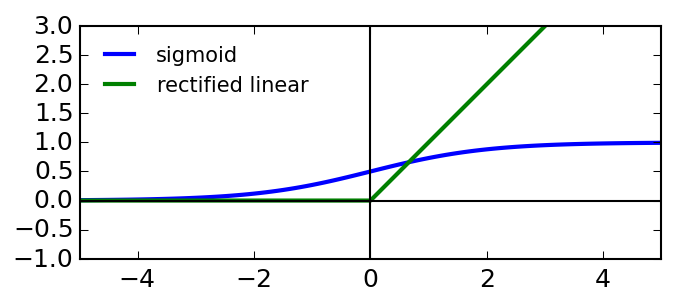

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 2)

x = np.linspace(-5, 5, 101)
y1 = 1 / (1 + np.exp(-x))
y2 = np.maximum(x, 0)

plt.plot(x, y1, label='sigmoid', lw=2)
plt.plot(x, y2, label='rectified linear', lw=2)
ax.plot([0, 0], [-1, 3], 'k-')
ax.plot([-5, 5], [0, 0], 'k-')
ax.set_xlim(-5, 5)
ax.set_ylim(-1, 3)
ax.set_aspect('equal')
ax.legend(loc=2, fontsize=10).draw_frame(False)

This greatly reduces the computation of both the activation of the neuron and the computation of the gradient.  This method also does not reduce the training ability of the neural net.

## Max norm

A very important concept in machine learning is normalization. Because of the potentially very large number of parameters in setting up the hidden layers, we can fit arbitrarily well to a given data set, but the resulting neural network does not generalize well to other data sets.  In order to prevent this from happening, we make sure the values of the weights do not become too large.  One way to do this is to add a cost proportional to the norm of the weight matrices to the NLL cost function. Another more computationally simple method is to enforce a maximum to the norm of the weight matrices. This has a similar effect to adding a cost to the weight norm.

## Dropout

Another normalization technique we implement is dropout.  To do this, on each iteration of training, a randomly selected selection of weights are temporarily zeroed. This has the dual effect of simplifying the computation, as each iteration only considers a subset of the neurons, and improves the training of the net. The basic idea behind dropout is to promote multiple independently reinforced pathways to activate the necessary neurons for each classification.

## Stochastic Gradient Descent

## Momentum

## Changing learning rate

# Using Pylearn2

# Results

# Training